In [4]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#print(torch.cuda.is_available())
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import noisereduce
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
#import torchvision
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import rcParams

In [5]:
lab_df = pd.read_csv('Summary_Emo_Eval.csv')

lab_dic = {}
for ind, row in lab_df.iterrows():
    label = row['emotion']
    if label == 'xxx':
        lab_dic[row['wav_filename']] = 'oth' # other
    elif label == 'exc': # excited
        lab_dic[row['wav_filename']] = 'hap' # happy
    else:
        lab_dic[row['wav_filename']] = label

In [6]:
dataset_dir = 'IEMOCAP/'

Y = []
mfcc_list = []

for session in [2]:#range(1,6)
    wav_sess_dir = dataset_dir + f'Session{session}/sentences/wav/'
    dialog_names = os.listdir(wav_sess_dir)
    for dialog in dialog_names:
        if dialog.startswith('.'):
            continue
        wav_dialog_dir = wav_sess_dir+dialog+'/'
        sentences_names = os.listdir(wav_dialog_dir)
        for sentence in sentences_names:
            if sentence.startswith('.'):
                continue
            if not sentence.endswith('wav'):
                continue
            label = [lab_dic[sentence[:-4]]]
            if not label[0] in ['ang','hap','sad','neu']:
                continue
            wav_sentence_path = wav_dialog_dir+sentence
            waveform, sr = librosa.load(wav_sentence_path, sr=None)
            mfcc = np.mean(librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=40).T, axis=0)
            Y.append(label)
            mfcc_list.append(mfcc.tolist())

In [7]:
X=mfcc_list
X_all = np.array(X)
enc = OneHotEncoder()
enc.fit([['ang'],['hap'],['sad'],['neu']])
Y_all = enc.transform(Y).toarray()

Xtrain, Xvaltest, Ytrain, Yvaltest = train_test_split(X_all, Y_all, test_size=0.2, random_state=42, shuffle=True)
Xval, Xtest, Yval, Ytest = train_test_split(Xvaltest, Yvaltest, test_size=0.5, random_state=42, shuffle=True)

Xtrain_c = np.expand_dims(Xtrain, axis=1)
Xval_c = np.expand_dims(Xval, axis=1)
Xtest_c = np.expand_dims(Xtest, axis=1)

In [8]:
class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 256, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(256, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(0.1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(128, 128, 5, padding=2)
        self.conv5 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.conv6 = nn.Conv1d(128, 128, 5, padding=2)
        self.fc = nn.Linear(640, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

net = NNModel()

In [9]:
Xtrain_ts  = torch.Tensor(Xtrain_c)
Ytrain_ts  = torch.Tensor(Ytrain)

Xval_ts = torch.Tensor(Xval_c)
Yval_ts = torch.Tensor(Yval)

Xtest_ts = torch.Tensor(Xtest_c)
Ytest_ts = torch.Tensor(Ytest)

batch_size = 4

train_set = torch.utils.data.TensorDataset(Xtrain_ts,Ytrain_ts)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=False,num_workers=2)

val_set = torch.utils.data.TensorDataset(Xval_ts,Yval_ts)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=False,num_workers=2)

test_set = torch.utils.data.TensorDataset(Xtest_ts,Ytest_ts)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=2)

In [10]:
def Tlabels(a):
    L1=[]
    for x in a:
        L1.append(x)
    return L1


def Plabels(b):
    L2=[]
    for x in b:
        L2.append(x)
    return L2

def conf_mat(cm,L1,L2):
    if len(L2)<1:
        return cm
    for i in range(len(L1)):
        if L2[i]==L1[i]:
            cm[L1[i]][L1[i]]=cm[L1[i]][L1[i]]+1
        else:
            cm[L2[i]][L1[i]]=cm[L2[i]][L1[i]]+1
    return cm
            
def cmplot(cm):
    classes = ['ang','hap','sad','neu']
    confusion_matrix = np.array(cm,dtype=np.int)
    proportion=[]
    for i in confusion_matrix:
        for j in i:
            temp=j/(np.sum(i))
            proportion.append(temp)
    pshow=[]
    for i in proportion:
        pt="%.2f%%" % (i * 100)
        pshow.append(pt)
    proportion=np.array(proportion).reshape(4,4)  
    pshow=np.array(pshow).reshape(4,4)
    #print(pshow)
    config = {
        "font.family":'Times New Roman',  
    }
    rcParams.update(config)
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Blues) 
    plt.title('confusion_matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)
    
    thresh = confusion_matrix.max() / 2.

    iters = np.reshape([[[i,j] for j in range(4)] for i in range(4)],(confusion_matrix.size,2))
    for i, j in iters:
        if(i==j):
            plt.text(j, i - 0.12, format(confusion_matrix[i, j]), va='center', ha='center', fontsize=12,color='white',weight=5) 
            plt.text(j, i + 0.12, pshow[i, j], va='center', ha='center', fontsize=12,color='white')
        else:
            plt.text(j, i-0.12, format(confusion_matrix[i, j]),va='center',ha='center',fontsize=12)
            plt.text(j, i+0.12, pshow[i, j], va='center', ha='center', fontsize=12)
    
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predict label',fontsize=16)
    plt.tight_layout()
    return plt.show()

    

Epoch     1:
Training Loss 0.304; Training Acc 51.834%; Validation Acc 41.176%; Test Acc 33.981%


c:\Python\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


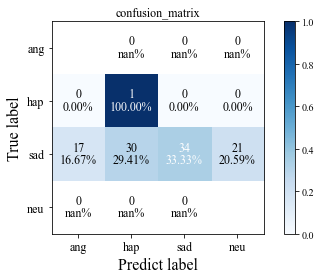

Epoch    10:
Training Loss 0.278; Training Acc 62.225%; Validation Acc 47.059%; Test Acc 52.427%


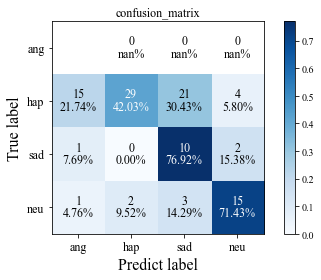

Epoch    20:
Training Loss 0.270; Training Acc 65.526%; Validation Acc 46.078%; Test Acc 51.456%


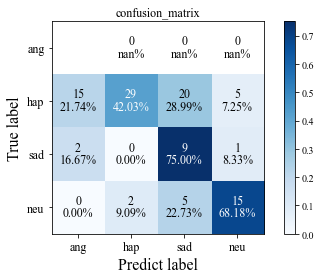

Epoch    30:
Training Loss 0.257; Training Acc 71.394%; Validation Acc 43.137%; Test Acc 43.689%


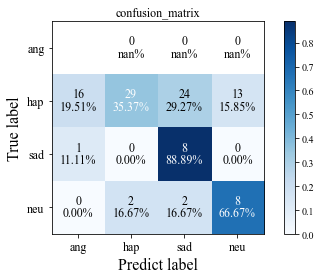

Epoch    40:
Training Loss 0.255; Training Acc 72.738%; Validation Acc 46.078%; Test Acc 44.660%


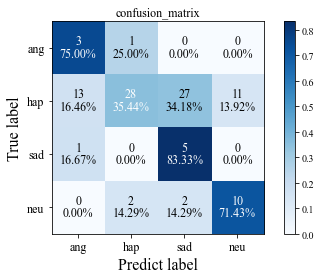

Epoch    50:
Training Loss 0.248; Training Acc 75.061%; Validation Acc 47.059%; Test Acc 54.369%


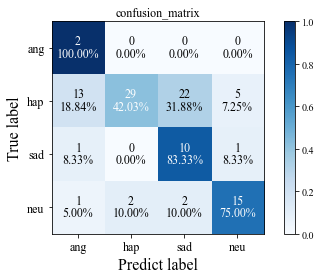

Epoch    60:
Training Loss 0.235; Training Acc 80.685%; Validation Acc 55.882%; Test Acc 52.427%


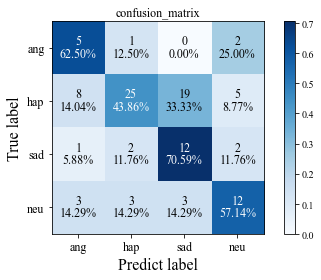

Epoch    70:
Training Loss 0.235; Training Acc 80.440%; Validation Acc 58.824%; Test Acc 54.369%


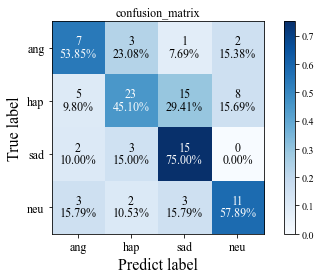

Epoch    80:
Training Loss 0.233; Training Acc 80.562%; Validation Acc 56.863%; Test Acc 57.282%


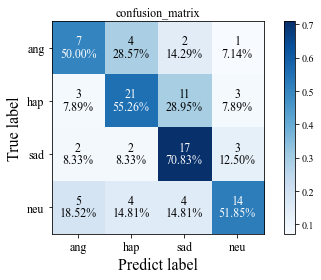

Epoch    90:
Training Loss 0.223; Training Acc 85.575%; Validation Acc 49.020%; Test Acc 52.427%


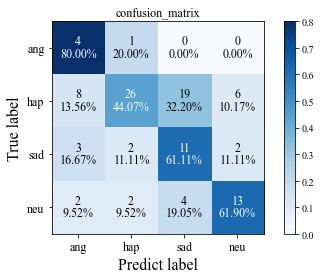

Epoch   100:
Training Loss 0.222; Training Acc 86.186%; Validation Acc 61.765%; Test Acc 58.252%


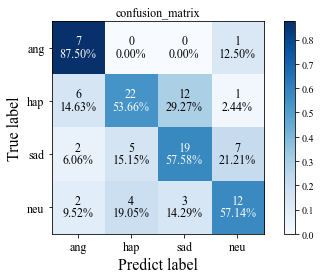

Epoch   110:
Training Loss 0.218; Training Acc 87.531%; Validation Acc 56.863%; Test Acc 56.311%


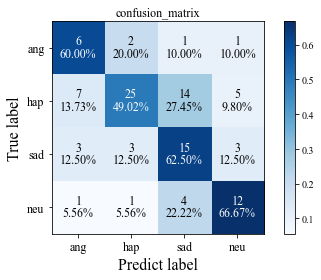

Epoch   120:
Training Loss 0.218; Training Acc 87.408%; Validation Acc 58.824%; Test Acc 60.194%


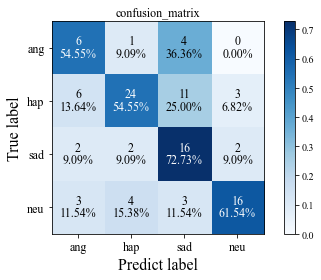

Epoch   130:
Training Loss 0.210; Training Acc 90.587%; Validation Acc 55.882%; Test Acc 51.456%


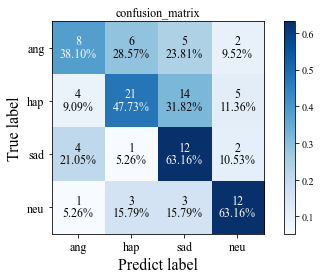

Epoch   140:
Training Loss 0.211; Training Acc 90.342%; Validation Acc 56.863%; Test Acc 56.311%


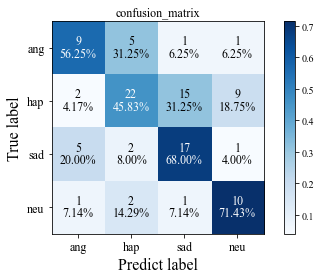

Epoch   150:
Training Loss 0.208; Training Acc 91.565%; Validation Acc 51.961%; Test Acc 50.485%


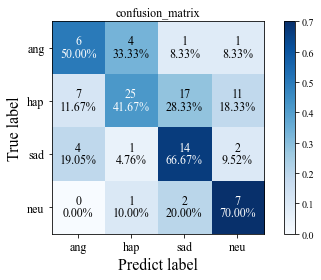

Epoch   160:
Training Loss 0.209; Training Acc 90.831%; Validation Acc 58.824%; Test Acc 60.194%


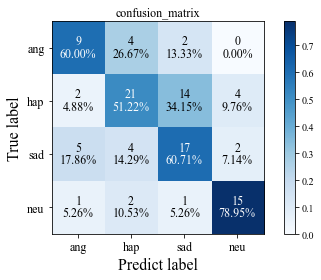

Epoch   170:
Training Loss 0.205; Training Acc 92.543%; Validation Acc 55.882%; Test Acc 63.107%


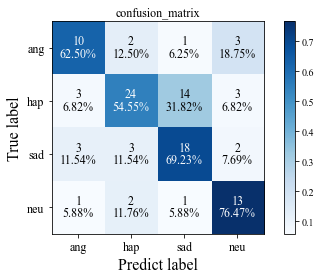

Epoch   180:
Training Loss 0.211; Training Acc 90.220%; Validation Acc 59.804%; Test Acc 58.252%


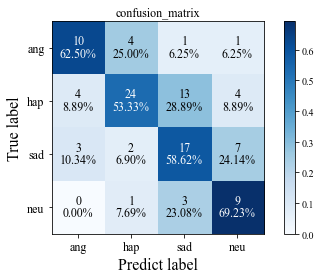

Epoch   190:
Training Loss 0.204; Training Acc 92.910%; Validation Acc 54.902%; Test Acc 59.223%


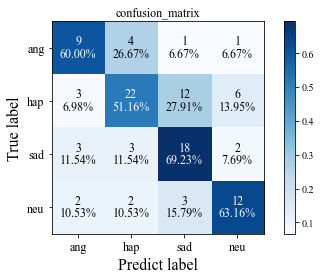

Epoch   200:
Training Loss 0.205; Training Acc 92.543%; Validation Acc 58.824%; Test Acc 60.194%


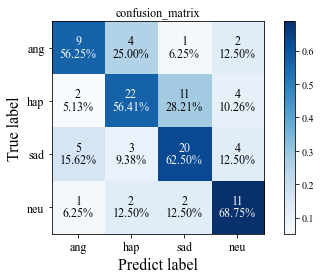

Epoch   210:
Training Loss 0.201; Training Acc 94.377%; Validation Acc 57.843%; Test Acc 59.223%


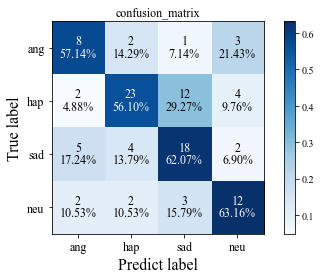

Epoch   220:
Training Loss 0.200; Training Acc 94.743%; Validation Acc 56.863%; Test Acc 57.282%


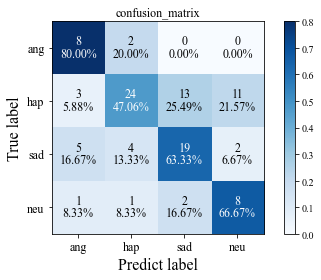

Epoch   230:
Training Loss 0.201; Training Acc 93.643%; Validation Acc 59.804%; Test Acc 61.165%


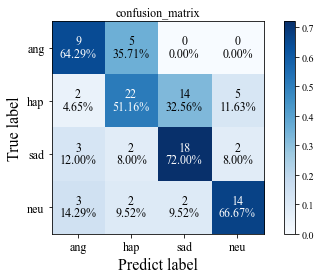

Epoch   240:
Training Loss 0.199; Training Acc 94.988%; Validation Acc 57.843%; Test Acc 66.019%


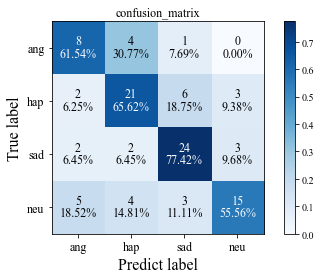

Epoch   250:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 60.784%; Test Acc 57.282%


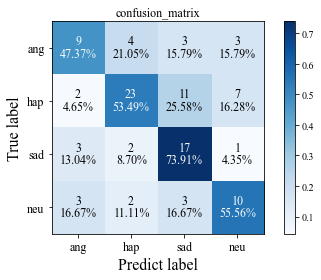

Epoch   260:
Training Loss 0.204; Training Acc 93.032%; Validation Acc 61.765%; Test Acc 58.252%


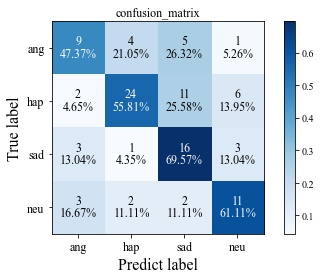

Epoch   270:
Training Loss 0.203; Training Acc 93.643%; Validation Acc 62.745%; Test Acc 61.165%


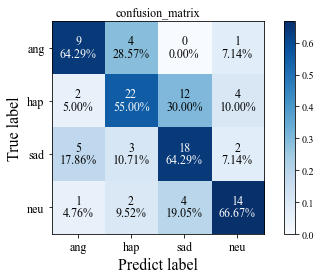

Epoch   280:
Training Loss 0.203; Training Acc 93.643%; Validation Acc 59.804%; Test Acc 63.107%


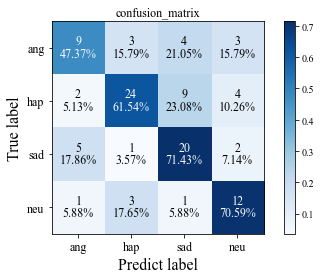

Epoch   290:
Training Loss 0.200; Training Acc 94.743%; Validation Acc 65.686%; Test Acc 60.194%


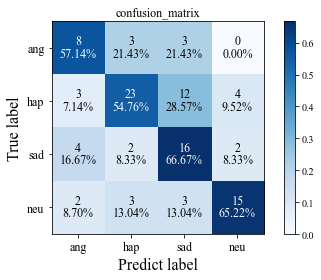

Epoch   300:
Training Loss 0.201; Training Acc 94.010%; Validation Acc 57.843%; Test Acc 53.398%


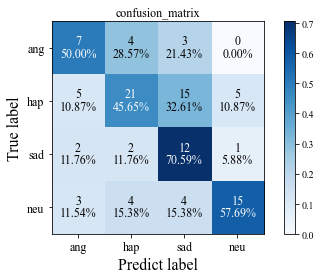

Epoch   310:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 59.804%; Test Acc 60.194%


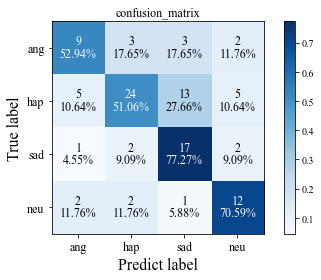

Epoch   320:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 61.765%; Test Acc 63.107%


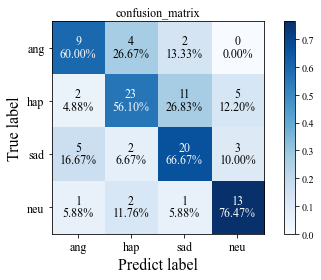

Epoch   330:
Training Loss 0.201; Training Acc 93.888%; Validation Acc 59.804%; Test Acc 62.136%


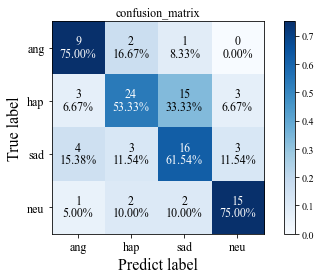

Epoch   340:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 58.824%; Test Acc 64.078%


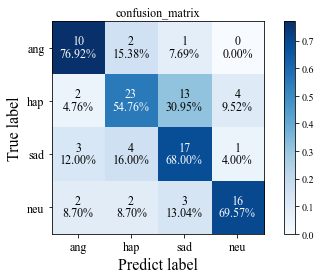

Epoch   350:
Training Loss 0.198; Training Acc 95.355%; Validation Acc 65.686%; Test Acc 62.136%


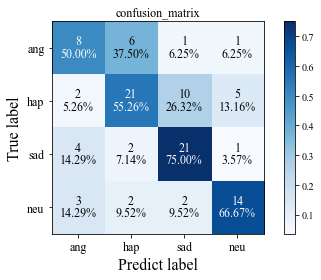

Epoch   360:
Training Loss 0.201; Training Acc 94.254%; Validation Acc 62.745%; Test Acc 66.019%


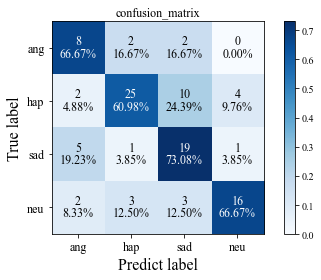

Epoch   370:
Training Loss 0.200; Training Acc 94.743%; Validation Acc 58.824%; Test Acc 57.282%


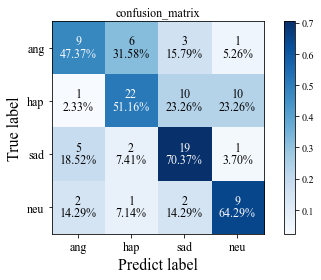

Epoch   380:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 60.784%; Test Acc 60.194%


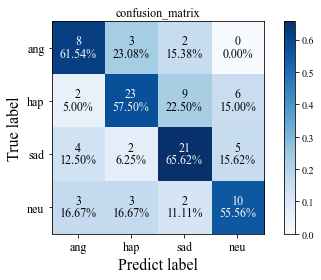

Epoch   390:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 62.745%; Test Acc 62.136%


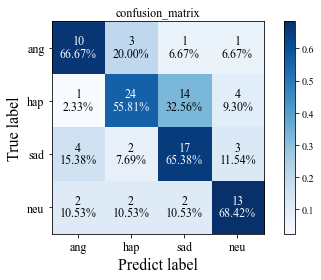

Epoch   400:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 56.863%; Test Acc 61.165%


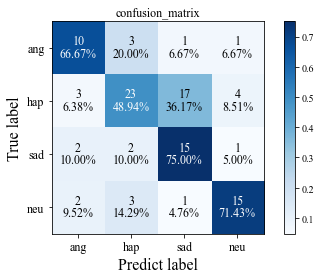

Epoch   410:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 61.765%; Test Acc 66.990%


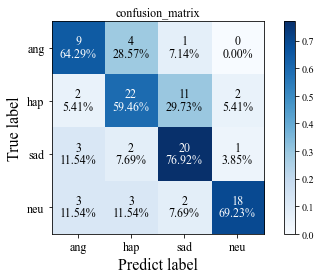

Epoch   420:
Training Loss 0.198; Training Acc 95.355%; Validation Acc 58.824%; Test Acc 63.107%


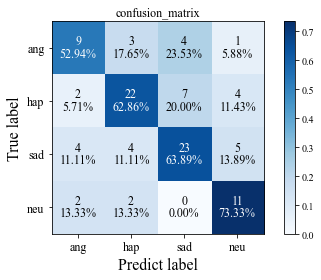

Epoch   430:
Training Loss 0.196; Training Acc 95.966%; Validation Acc 59.804%; Test Acc 61.165%


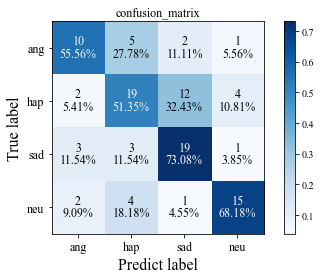

Epoch   440:
Training Loss 0.196; Training Acc 96.210%; Validation Acc 54.902%; Test Acc 64.078%


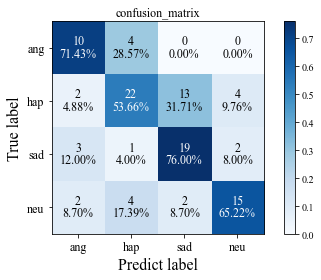

Epoch   450:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 59.804%; Test Acc 59.223%


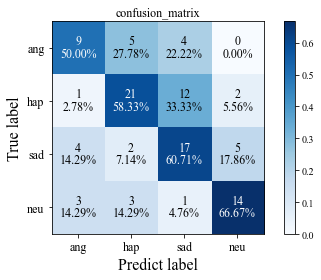

Epoch   460:
Training Loss 0.196; Training Acc 96.210%; Validation Acc 56.863%; Test Acc 60.194%


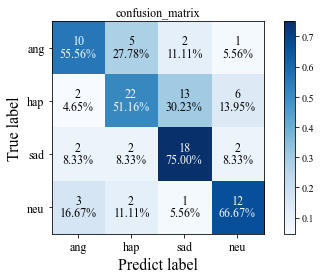

Epoch   470:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 56.863%; Test Acc 58.252%


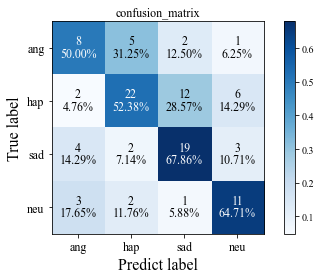

Epoch   480:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 58.824%; Test Acc 59.223%


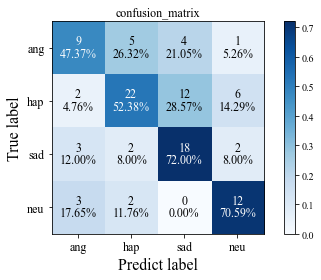

Epoch   490:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 57.843%; Test Acc 60.194%


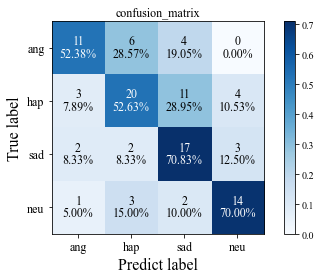

Epoch   500:
Training Loss 0.195; Training Acc 96.455%; Validation Acc 58.824%; Test Acc 59.223%


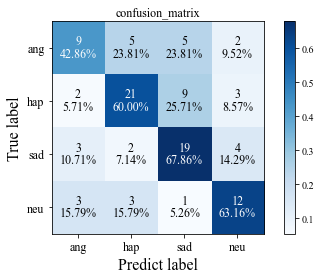

Epoch   510:
Training Loss 0.196; Training Acc 96.088%; Validation Acc 61.765%; Test Acc 60.194%


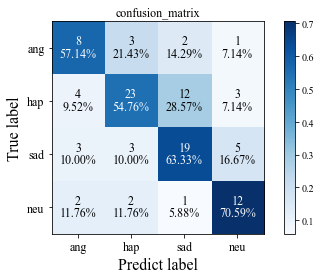

Epoch   520:
Training Loss 0.196; Training Acc 96.088%; Validation Acc 63.725%; Test Acc 65.049%


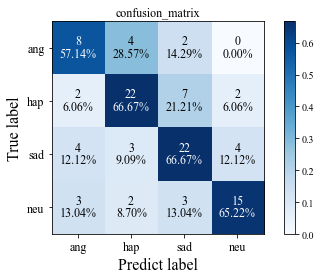

Epoch   530:
Training Loss 0.195; Training Acc 96.455%; Validation Acc 54.902%; Test Acc 54.369%


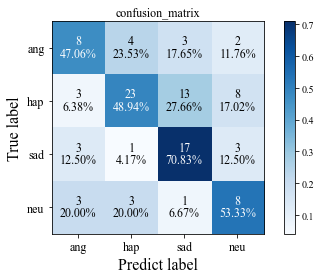

Epoch   540:
Training Loss 0.199; Training Acc 94.988%; Validation Acc 50.980%; Test Acc 53.398%


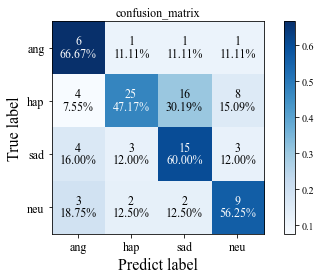

Epoch   550:
Training Loss 0.196; Training Acc 96.333%; Validation Acc 57.843%; Test Acc 57.282%


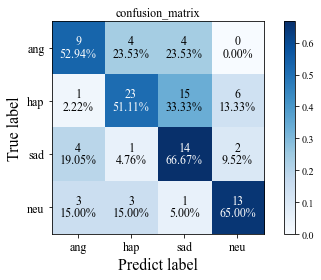

Epoch   560:
Training Loss 0.195; Training Acc 96.455%; Validation Acc 56.863%; Test Acc 58.252%


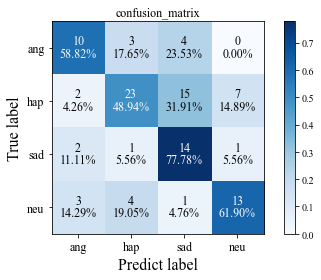

Epoch   570:
Training Loss 0.196; Training Acc 96.088%; Validation Acc 56.863%; Test Acc 62.136%


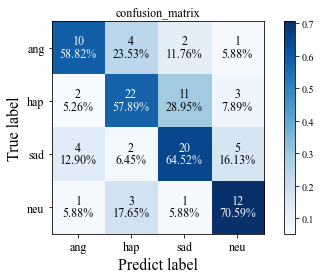

Epoch   580:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 55.882%; Test Acc 63.107%


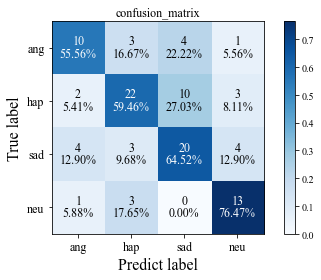

Epoch   590:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 59.804%; Test Acc 64.078%


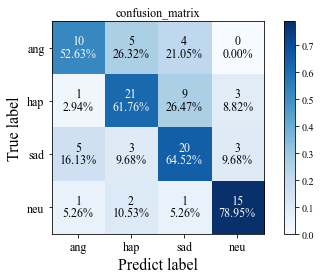

Epoch   600:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 54.902%; Test Acc 57.282%


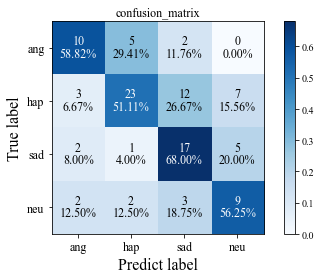

Epoch   610:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 57.843%; Test Acc 61.165%


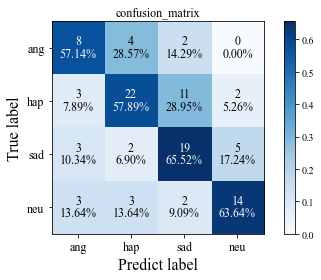

Epoch   620:
Training Loss 0.195; Training Acc 96.455%; Validation Acc 58.824%; Test Acc 63.107%


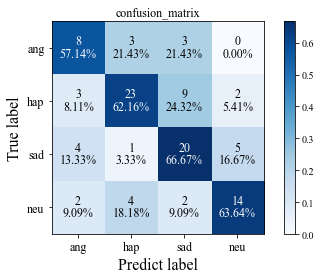

Epoch   630:
Training Loss 0.196; Training Acc 96.210%; Validation Acc 57.843%; Test Acc 61.165%


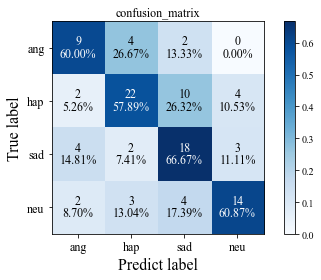

Epoch   640:
Training Loss 0.196; Training Acc 95.966%; Validation Acc 56.863%; Test Acc 55.340%


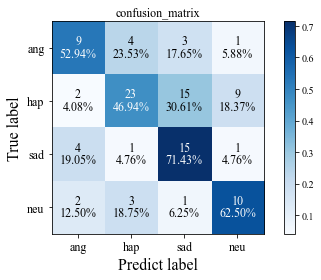

Epoch   650:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 57.843%; Test Acc 60.194%


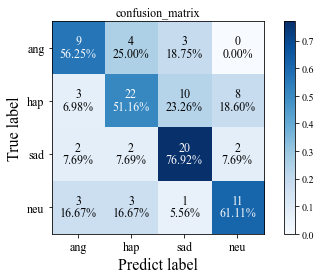

Epoch   660:
Training Loss 0.195; Training Acc 96.455%; Validation Acc 59.804%; Test Acc 64.078%


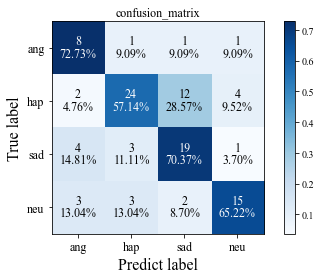

Epoch   670:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 57.843%; Test Acc 62.136%


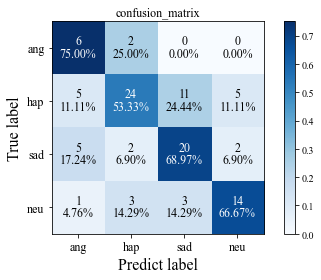

Epoch   680:
Training Loss 0.195; Training Acc 96.577%; Validation Acc 62.745%; Test Acc 66.019%


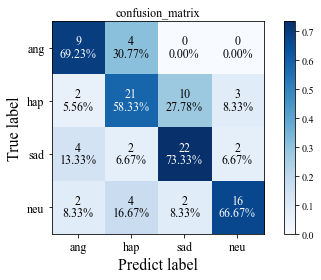

Epoch   690:
Training Loss 0.195; Training Acc 96.577%; Validation Acc 60.784%; Test Acc 66.990%


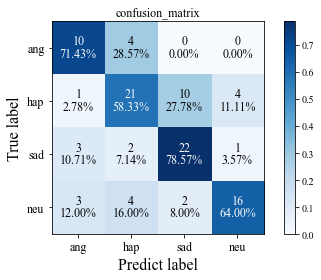

Epoch   700:
Training Loss 0.200; Training Acc 94.499%; Validation Acc 61.765%; Test Acc 61.165%


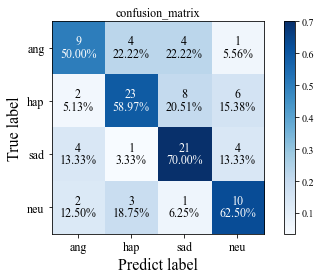

Epoch   710:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 60.784%; Test Acc 62.136%


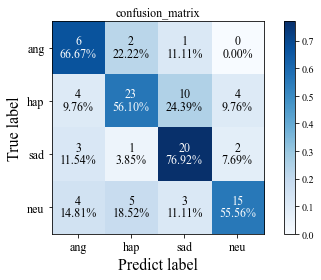

Epoch   720:
Training Loss 0.195; Training Acc 96.455%; Validation Acc 58.824%; Test Acc 59.223%


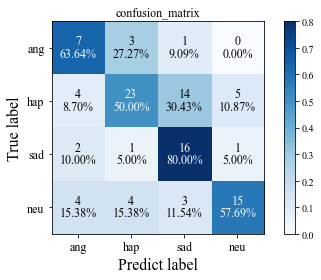

Epoch   730:
Training Loss 0.195; Training Acc 96.699%; Validation Acc 62.745%; Test Acc 64.078%


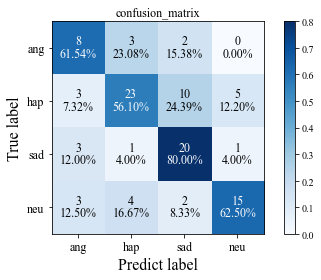

Epoch   740:
Training Loss 0.195; Training Acc 96.577%; Validation Acc 59.804%; Test Acc 60.194%


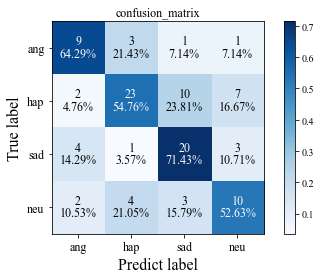

Epoch   750:
Training Loss 0.195; Training Acc 96.699%; Validation Acc 61.765%; Test Acc 64.078%


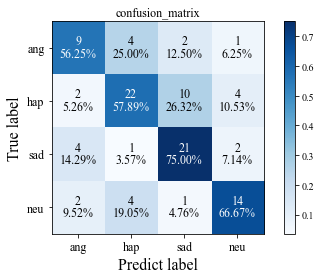

Epoch   760:
Training Loss 0.195; Training Acc 96.699%; Validation Acc 60.784%; Test Acc 63.107%


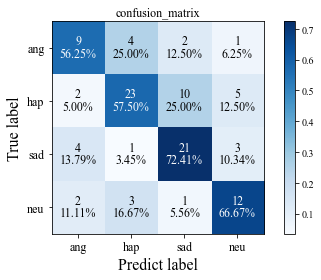

Epoch   770:
Training Loss 0.195; Training Acc 96.577%; Validation Acc 59.804%; Test Acc 66.019%


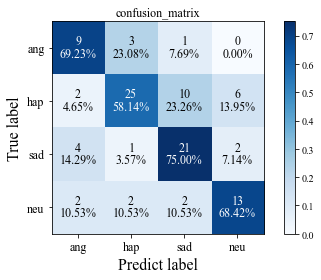

Epoch   780:
Training Loss 0.195; Training Acc 96.333%; Validation Acc 57.843%; Test Acc 64.078%


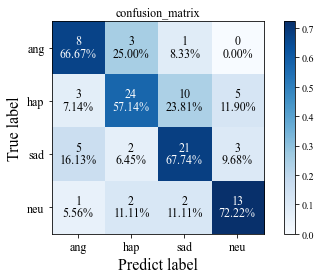

Epoch   790:
Training Loss 0.195; Training Acc 96.699%; Validation Acc 60.784%; Test Acc 66.019%


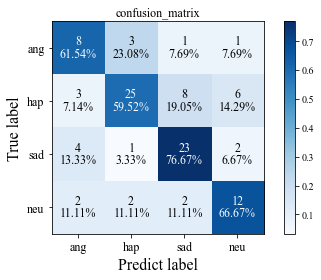

Epoch   800:
Training Loss 0.196; Training Acc 96.210%; Validation Acc 57.843%; Test Acc 65.049%


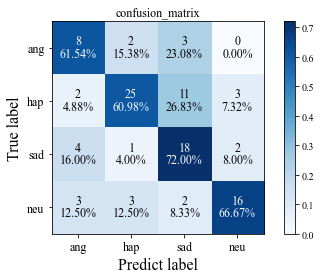

Epoch   810:
Training Loss 0.194; Training Acc 96.822%; Validation Acc 58.824%; Test Acc 59.223%


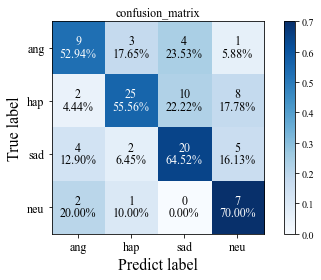

Epoch   820:
Training Loss 0.194; Training Acc 96.822%; Validation Acc 58.824%; Test Acc 64.078%


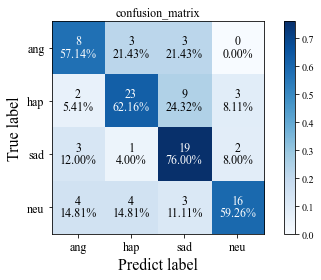

Epoch   830:
Training Loss 0.196; Training Acc 96.333%; Validation Acc 62.745%; Test Acc 59.223%


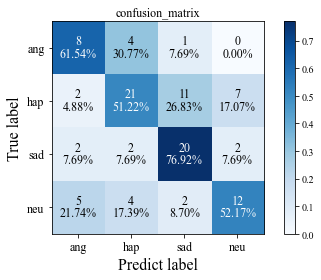

Epoch   840:
Training Loss 0.194; Training Acc 96.822%; Validation Acc 59.804%; Test Acc 61.165%


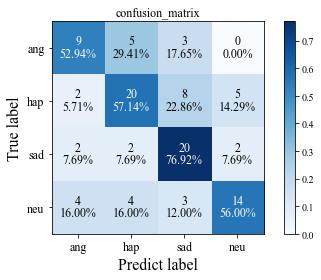

Epoch   850:
Training Loss 0.194; Training Acc 96.822%; Validation Acc 61.765%; Test Acc 62.136%


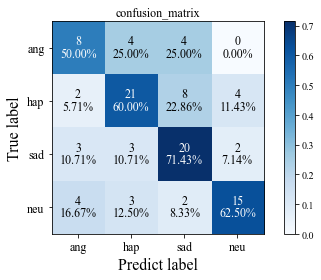

Epoch   860:
Training Loss 0.194; Training Acc 96.822%; Validation Acc 58.824%; Test Acc 58.252%


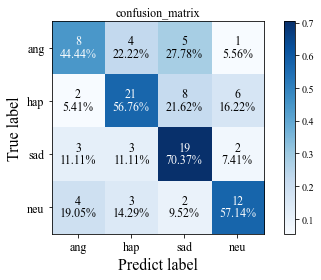

Epoch   870:
Training Loss 0.194; Training Acc 96.822%; Validation Acc 61.765%; Test Acc 61.165%


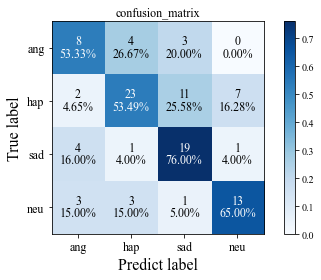

Epoch   880:
Training Loss 0.194; Training Acc 96.822%; Validation Acc 60.784%; Test Acc 62.136%


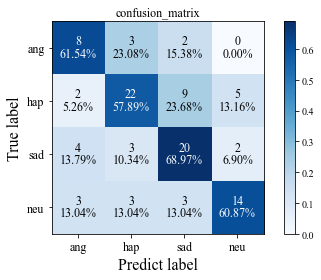

Epoch   890:
Training Loss 0.195; Training Acc 96.699%; Validation Acc 60.784%; Test Acc 59.223%


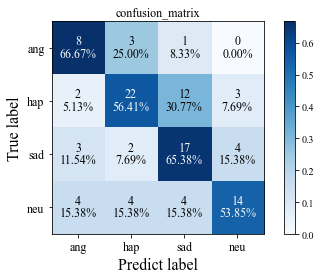

Epoch   900:
Training Loss 0.195; Training Acc 96.455%; Validation Acc 61.765%; Test Acc 60.194%


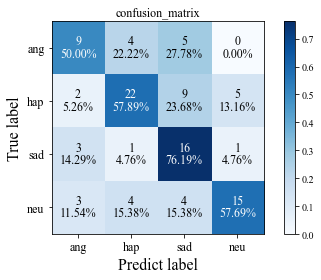

Epoch   910:
Training Loss 0.195; Training Acc 96.577%; Validation Acc 59.804%; Test Acc 60.194%


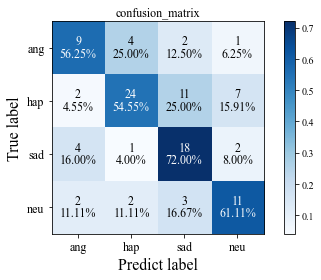

Epoch   920:
Training Loss 0.194; Training Acc 96.944%; Validation Acc 64.706%; Test Acc 62.136%


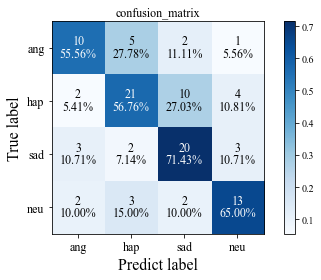

Epoch   930:
Training Loss 0.194; Training Acc 96.944%; Validation Acc 65.686%; Test Acc 65.049%


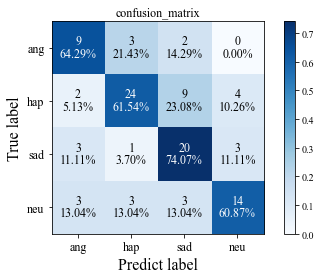

Epoch   940:
Training Loss 0.195; Training Acc 96.822%; Validation Acc 66.667%; Test Acc 64.078%


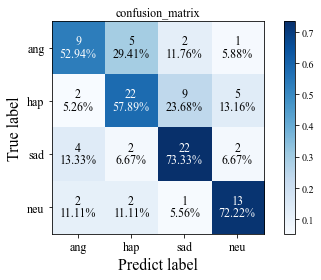

Epoch   950:
Training Loss 0.194; Training Acc 96.944%; Validation Acc 64.706%; Test Acc 61.165%


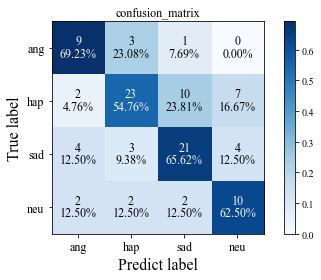

Epoch   960:
Training Loss 0.194; Training Acc 96.822%; Validation Acc 62.745%; Test Acc 64.078%


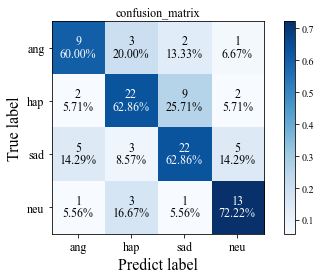

Epoch   970:
Training Loss 0.196; Training Acc 96.210%; Validation Acc 60.784%; Test Acc 60.194%


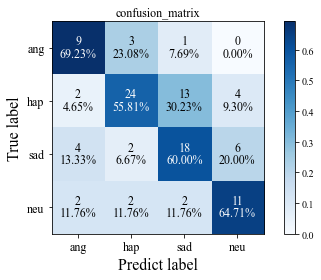

Epoch   980:
Training Loss 0.195; Training Acc 96.577%; Validation Acc 59.804%; Test Acc 61.165%


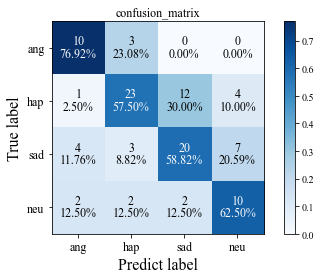

Epoch   990:
Training Loss 0.194; Training Acc 96.944%; Validation Acc 61.765%; Test Acc 60.194%


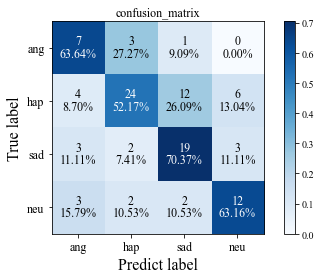

Epoch  1000:
Training Loss 0.194; Training Acc 96.944%; Validation Acc 66.667%; Test Acc 65.049%


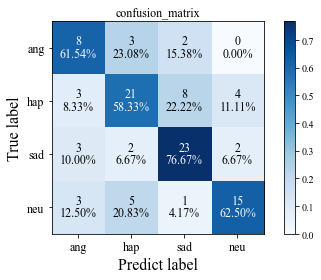

Finished training


In [12]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()

epochs = 1000

for epoch in range(1, epochs+1):
    cm=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    test_acc = 0.0
    for batch, (inputs,targets) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        preds = torch.max(outputs, 1)[1]
        classes = torch.max(targets, 1)[1]
        train_correct = (preds == classes).sum()
        train_acc += train_correct.item()
        train_loss += loss.item()
    if epoch % 10 == 0 or epoch == 1:
        with torch.no_grad():
            net.eval()
            for inputs,targets in val_loader:
                outputs = net(inputs)
                preds = torch.max(outputs, 1)[1]
                classes = torch.max(targets, 1)[1]
                val_correct = (preds == classes).sum()
                val_acc += val_correct.item()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
            for inputs,targets in test_loader:
                outputs = net(inputs)
                preds = torch.max(outputs, 1)[1]
                classes = torch.max(targets, 1)[1]
                cm=conf_mat(cm,Tlabels(classes.numpy()),Plabels(preds.numpy()))
                test_correct = (preds == classes).sum()
                test_acc += test_correct.item()
            net.train()
        Train_loss = train_loss/(len(train_set))
        Train_acc = 100*train_acc/(len(train_set))
        Val_acc = 100*val_acc/(len(val_set))
        Test_acc = 100*test_acc/(len(test_set))
        print(f'Epoch {epoch:5d}:')
        print(f'Training Loss {Train_loss:.3f}; Training Acc {Train_acc:.3f}%; Validation Acc {Val_acc:.3f}%; Test Acc {Test_acc:.3f}%')        
        cmplot(cm)
print('Finished training')

# after training, choose epoch based on validation accuracy
# to do:
# plot the loss/accuracy
# get confusion matrix
